In [2]:
import polars as pl
import seaborn as sns
import polars.selectors as cs
import matplotlib.pyplot as plt

df_anage = pl.read_csv("../../data/anage.csv", ignore_errors=True)
df_earthq = pl.read_csv("../../data/EarthquakesChile_2000-2024.csv")

### Crea un gráfico de barras que muestre las longevidades máximas de las especies de la clase “Holostei” en el dataset anage. Utiliza el nombre común de cada animal en el eje X.

<Axes: xlabel='Common name', ylabel='Maximum longevity (yrs)'>

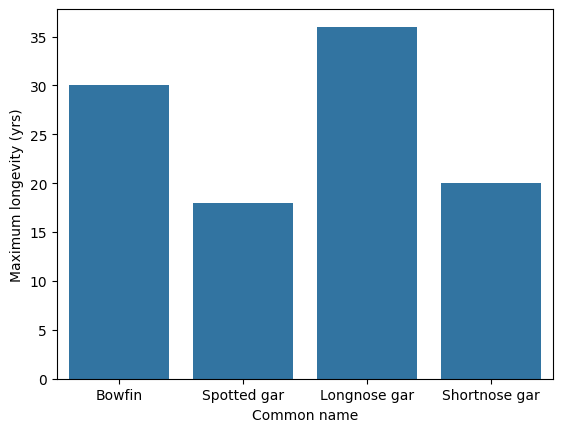

In [5]:
# sns.barplot(df_anage.filter(pl.col("Class").str.contains("Holostei")), x="Common name", y="Maximum longevity (yrs)")
sns.barplot(df_anage.filter(pl.col("Class") == "Holostei"), x="Common name", y="Maximum longevity (yrs)")

### Crea un gráfico de barras que muestre el total de sismos con magnitud 5.0 o superior por año usando el dataset de sismos de Chile. ¿Qué año tuvo la mayor cantidad de sismos?

<Axes: xlabel='year', ylabel='count'>

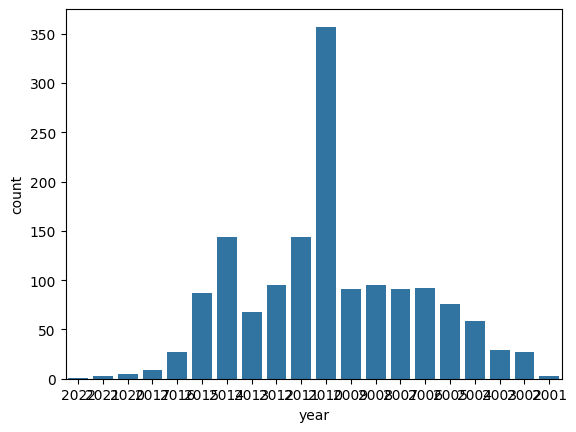

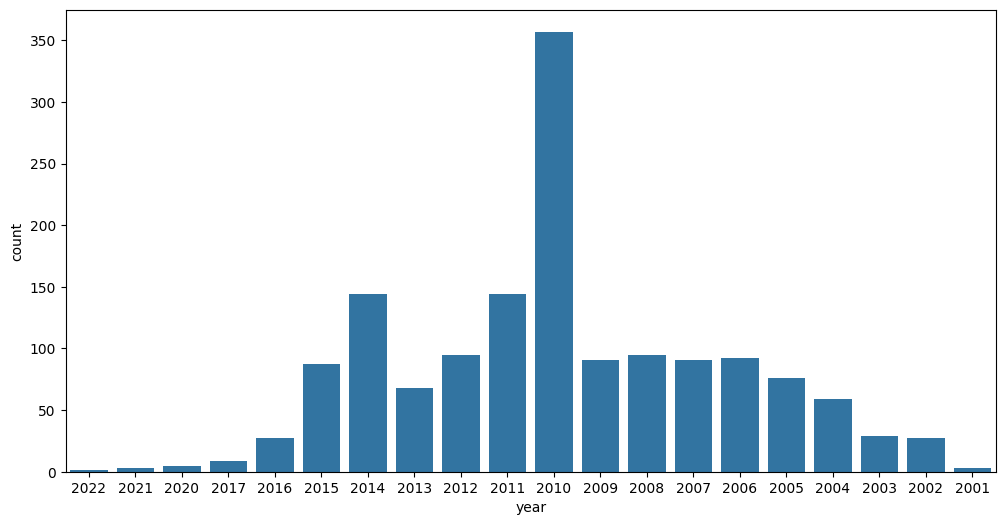

In [14]:
df_earthq = df_earthq.with_columns(year = pl.col("Date").str.slice(0,4)) 
df_earthq = df_earthq.with_columns(year = pl.col("Date").str.split("-").list[0]) 

sns.countplot(df_earthq.filter(pl.col("Magnitude_Ml")>=5), x="year")

plt.figure(figsize=(12,6))
sns.countplot(df_earthq.filter(pl.col("Magnitude_Ml")>=5), x="year")


### Crea un gráfico de barras agrupadas que muestre la temperatura en grados Celsius por clase y origen de los animales del dataset anage. Personaliza los colores de las barras para cada categoría. ¿Hay diferencias entre los animales salvajes y en cautiverio?

<Axes: xlabel='Class', ylabel='Temperature (C)'>

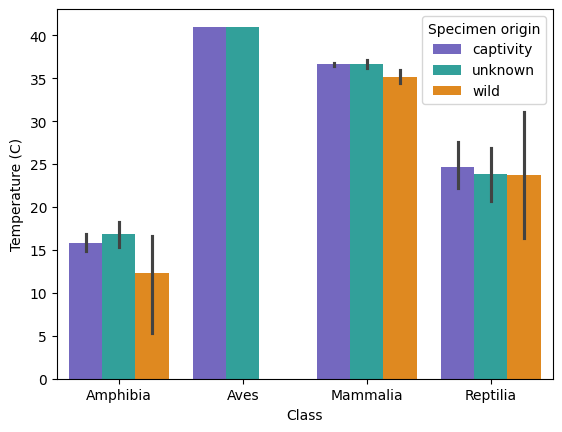

In [22]:
df_anage_subset = (df_anage
                   .select("Class","Specimen origin","Temperature (K)")
                   .drop_nulls(subset="Temperature (K)")
                   .with_columns((pl.col("Temperature (K)")-273.15).alias("Temperature (C)"))
                   
                    )
sns.barplot(df_anage_subset, x="Class", y="Temperature (C)", hue="Specimen origin", palette = ["slateblue","lightseagreen","darkorange"])

### Utiliza un gráfico de torta para representar la proporción de sismos por región con magnitud mayor o igual a 4 en el año 2015. Añade los nombres de las regiones en cada sector del gráfico.

([<matplotlib.patches.Wedge at 0x707facc68690>,
 [Text(1.38916522147242, 0.17383896988731282, 'Arica y Parinacota'),
  Text(1.343290167405915, 0.3944255647781829, 'Ñuble'),
  Text(1.2893069184795294, 0.5456076153801559, 'Atacama'),
  Text(1.2283409200418636, 0.6716982835698688, 'Santiago Metropolitan'),
  Text(1.2046733859699612, 0.7132755660582162, 'Los Lagos'),
  Text(1.1905156256136074, 0.7366631151142566, 'Araucanía'),
  Text(1.181436112735374, 0.7511382772331126, 'Magallanes y Antártica Chilena'),
  Text(1.0365064451596686, 0.9410921257467125, 'Valparaíso'),
  Text(0.8640787590109087, 1.1015297990640869, 'Aysén del General Ibañez del Cam'),
  Text(0.5877912436905676, 1.270630337210904, 'Tarapacá'),
  Text(0.09049877980564382, 1.397071927587728, 'Bío-Bío'),
  Text(-0.16196456146133237, 1.3905996838884431, "Libertador General Bernardo O'Hi"),
  Text(-1.3845083358279024, -0.20769368797113683, 'Coquimbo'),
  Text(0.20262297188508127, -1.38525951765886, 'Los Ríos'),
  Text(0.2833832843

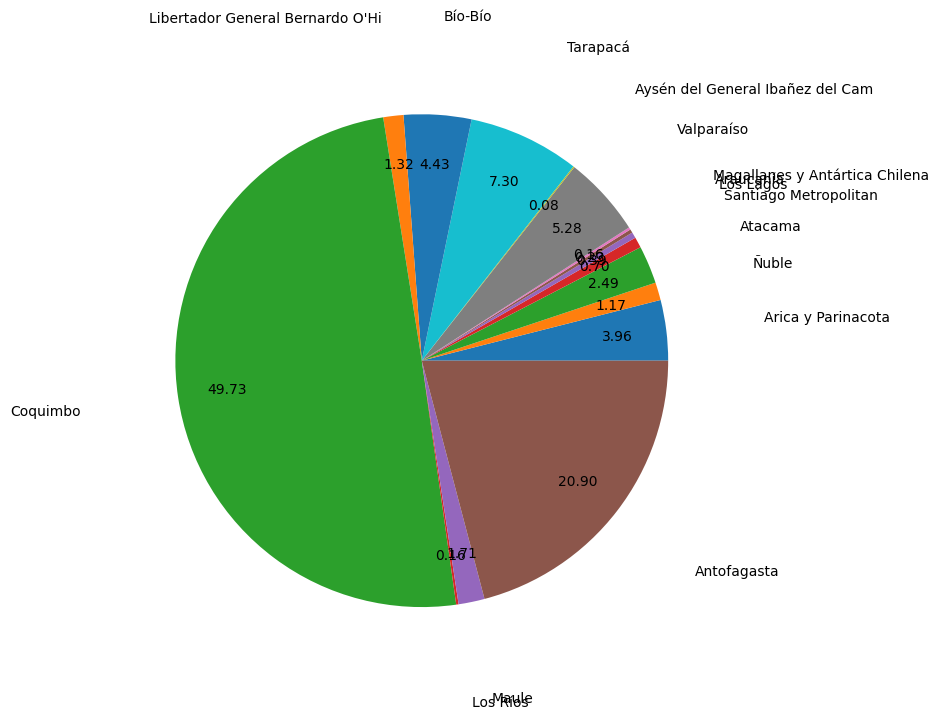

In [50]:
df_earthq_2015 = df_earthq.filter((pl.col("year")=="2015") & (pl.col("Magnitude_Ml")>=4))
df_earthq_2015 = df_earthq_2015.group_by("Region").len() 

plt.figure(figsize=(12,8))
plt.pie(df_earthq_2015["len"], labels=df_earthq_2015["Region"], rotatelabels=False, autopct="%.2f", pctdistance=0.8, labeldistance=1.4)



### Categoriza la longevidad de los animales del dataset anage en 3 grupos: “Corta” (menos de 5 años), “Media” (entre 5 y 15 años) y “Larga” (más de 15 años). Luego, crea un gráfico de barras apiladas que muestre la cantidad de animales en cada categoría de longevidad por clase.

<Axes: xlabel='Class'>

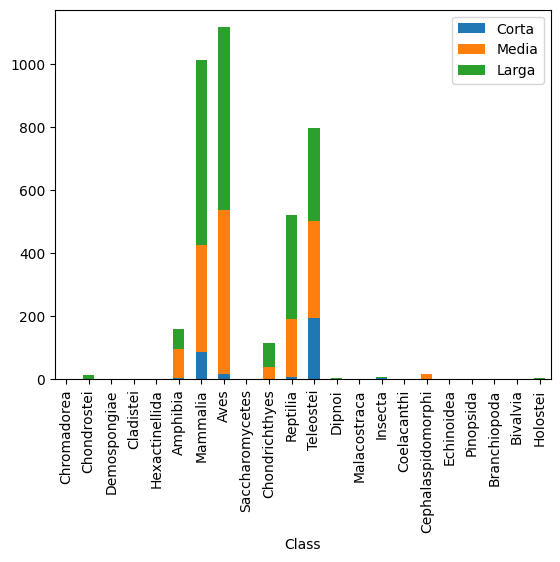

In [72]:
df_anage_long_cat = df_anage.drop_nulls(subset="Maximum longevity (yrs)")
df_anage_long_cat = df_anage_long_cat.with_columns(pl.when(pl.col("Maximum longevity (yrs)")<5)
                                          .then(pl.lit("Corta"))
                                          .when(pl.col("Maximum longevity (yrs)")<15)
                                          .then(pl.lit("Media"))
                                          .otherwise(pl.lit("Larga"))
                                          .alias("long_cat")
                        
                                          
                                          )


df_anage_long_cat = (df_anage_long_cat
                     .select("long_cat","Class")
                     .group_by("long_cat","Class").len()
                     .pivot(index="Class",on="long_cat")
                     .fill_null(0)
                     #.to_pandas()
                     #.set_index("Class")
                     )

df_anage_long_cat_pandas = df_anage_long_cat.to_pandas().set_index("Class")
df_anage_long_cat_pandas.plot(kind="bar", stacked=True)


In [ ]:
df_anage_long_cat_filter = df_anage_long_cat.filter(pl.all_horizontal("Corta","Media","Larga")!=0)                           
                            
df_anage_long_cat_filter_pandas = df_anage_long_cat_filter.to_pandas().set_index("Class")

<Axes: xlabel='Class'>

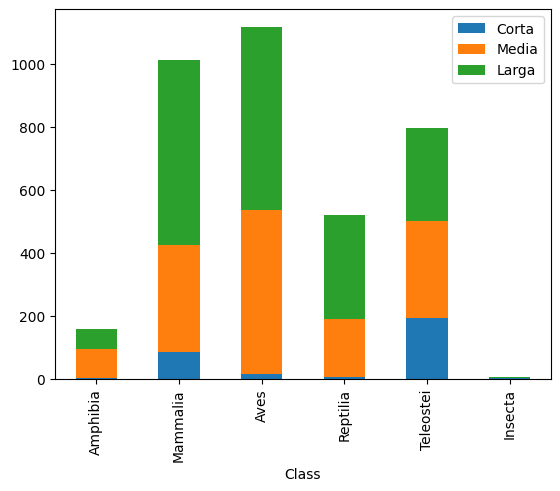

In [79]:
df_anage_long_cat_filter_pandas.plot(kind="bar",stacked=True)

<Axes: xlabel='Class'>

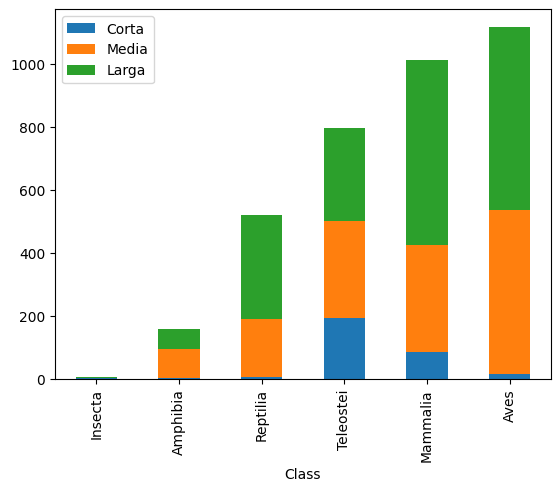

In [86]:
df_anage_long_cat_filter_sort = df_anage_long_cat_filter.sort(pl.sum_horizontal("Corta","Media","Larga"))
df_anage_long_cat_filter_sort_pandas = df_anage_long_cat_filter_sort.to_pandas().set_index("Class")
df_anage_long_cat_filter_sort_pandas.plot(kind="bar",stacked=True)

### Usando el mismo resumen obtenido en el ejercicio anterior, calcula el porcentaje de animales en cada categoría de longevidad dentro de cada clase. Luego, genera un gráfico de barras apiladas donde el eje Y represente proporciones (0–100%) en lugar de conteos absolutos.

<Axes: xlabel='Class'>

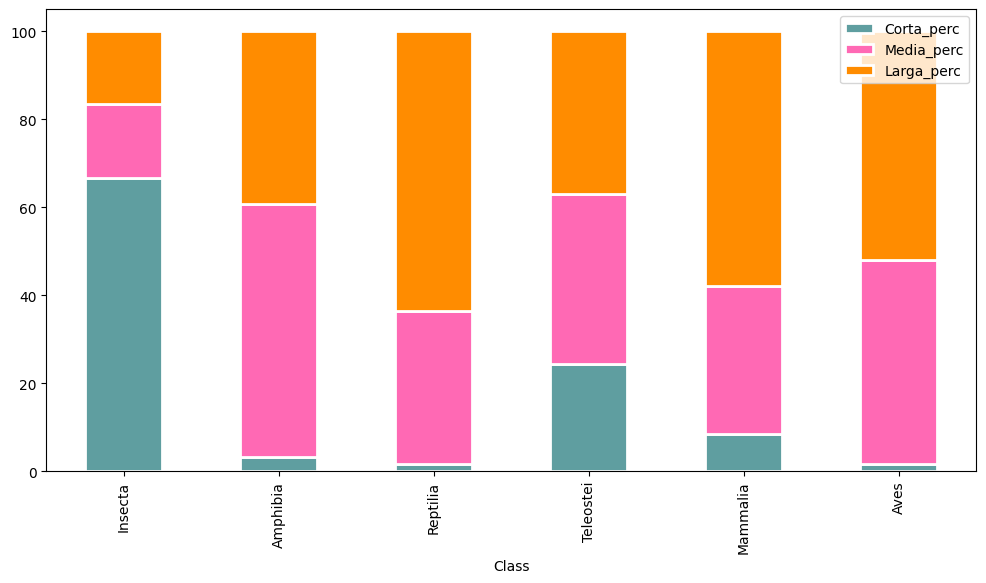

In [111]:
df_anage_long_cat_filter_sort_perc = df_anage_long_cat_filter_sort.with_columns(  ((pl.col("Corta")*100)/pl.sum_horizontal(cs.numeric())).round(2).alias("Corta_perc"),
                                            ((pl.col("Media")*100)/pl.sum_horizontal(cs.numeric())).round(2).alias("Media_perc"),
                                             ((pl.col("Larga")*100)/pl.sum_horizontal(cs.numeric())).round(2).alias("Larga_perc")
                                           
                                           ).select("Class","Corta_perc","Media_perc","Larga_perc")

df_anage_long_cat_filter_sort_perc_pandas = df_anage_long_cat_filter_sort_perc.to_pandas().set_index("Class")



df_anage_long_cat_filter_sort_perc_pandas.plot(kind="bar", stacked=True, linewidth=2, edgecolor="white", figsize=(12,6), color = ["cadetblue","hotpink","darkorange"])
